# **Práctico 5 (Parte 3): Cargar y explorar word embeddings pre-entrenados**

### Tabla de Contenidos
1. [Consigna](#1.-Consigna)
2. [Inicialización del entorno](#2.-Inicialización-del-entorno)
3. [Carga de word embeddings pre entrenados con GloVe](#3.-Carga-de-word-embeddings-pre-entrenados-con-GloVe)
4. [Carga de datos de los dialogos](#4.-Carga-de-datos-de-los-dialogos)
5. [Palabras no presentes en el modelo pre entrenado](#5.-Palabras-no-presentes-en-el-modelo-pre-entrenado)
6. [Selección de vocabulario aleatorio](#6.-Selección-de-vocabulario-aleatorio)
7. [Exploración de palabras por similitud](#7.-Exploración-de-palabras-por-similitud)
8. [Visualización](#8.-Visualización)
9. [Observaciones](#9.-Observaciones)

## 1. Consigna

En este ejercicio cargarán y explorarán word embeddings preentrenados, les recomiendo Glove usando la función most_similar y variando el valor de topn. Un tutorial sobre cómo hacerlo pueden encontrarse acá:

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Mostrar ejemplos usando most_similar que les resulten interesantes.

## 2. Inicialización del entorno

In [1]:
#Librerías 
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import re
from ast import literal_eval
import itertools
import random

# Para vectorizar los tokens
from sklearn.feature_extraction.text import CountVectorizer

# Embeddings
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Reducción de dimensionalidad
from sklearn.decomposition import PCA

# Gráficos
import matplotlib.pyplot as plt

## 3. Carga de word embeddings pre entrenados con GloVe 

Inicialmente vamos a explorar uno de los vectores de palabras preentrenados de dominio público disponibles en el website de GloVe de la Universidad de Stanford [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)

El archivo `glove.6B.zip` tiene las siguientes características: 

* Origen: Wikipedia 2014 + Gigaword 5 
* 6 mil millones de tokens
* Vocabulario: 400K  
* Minúsculas
* Vectores de 50d, 100d, 200d, & 300d 
* 822 MB 


In [2]:
data_dir = os.path.join('..', 'dataset')

#1 Archivo de entrada: GloVe
glove_input_file = 'glove.6B.100d.txt'
glove_input_file_full = os.path.join(data_dir, glove_input_file)

#2 Archivo de salida: Word2Vec 
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
word2vec_output_file_full = os.path.join(data_dir, word2vec_output_file)

#3 Conversión
glove2word2vec(glove_input_file_full, word2vec_output_file_full)

(400000, 100)

In [3]:
#4 Carga del modelo
model = KeyedVectors.load_word2vec_format(word2vec_output_file_full, binary=False)

In [4]:
#5 Tamaño del vocabulario
print('\nTamaño del vocabulario del modelo GloVe: {} palabras'.format(len(list(model.wv.vocab))))


Tamaño del vocabulario del modelo GloVe: 400000 palabras


## 4. Carga de datos de los dialogos

Nos interesa utilizar el modelo preentrenado para nuestro problema específico. Con ese objetivo cargamos los datos de los dialogos entre tutores y estudiantes para explorar el comportamiento con ese vocabulario particular 

In [5]:
#1 Carga de los datos de los dialogos
filename = 'yup_curated_data.csv'
datos_curados = pd.read_csv(os.path.join('..', 'dataset', filename))

#2 Remoción de las sesiones de pocos dialogos
n_short_sessions = len(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)])
datos_curados = datos_curados.drop(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)].index)

#3 Remoción de los dialogos sin contenido
n_null_token_tutor = datos_curados['tokens_tutor'].isnull().sum()
n_null_token_student = datos_curados['tokens_student'].isnull().sum()
datos_curados = datos_curados.dropna(subset=['tokens_tutor','tokens_student'])

datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: literal_eval(x))
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: literal_eval(x))

#4 Utilizamos expresiones regulares para unificar los unigramas bajo el tag <math>
r = re.compile('((?=.*[0-9])(?=.*[%\/\(\)\^\\\+\-\*\=]))^.*')
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: ['<math>' if r.match(w) else w for w in x])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: ['<math>' if r.match(w) else w for w in x])

datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: str(x)[1:-1])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: str(x)[1:-1])

#5 Unimos loa díalogos del tutor y del estudiante para vectorizarlos
datos_curados['tokens'] = datos_curados['tokens_tutor'] +', '+ datos_curados['tokens_student']
tokens = datos_curados['tokens']

#6 Utilizamos la técnica de Bag Of Words para reunir un vocabulario del cual exceptuamos:
#  * Los tokens de más baja frecuencia
#  * Los tokens de más alta frecuencia 
vectorizer_dialogos = CountVectorizer(min_df= 0.005, max_df= 0.35)
bow = vectorizer_dialogos.fit_transform(tokens)         

print('Nos quedamos con un vocabulario de {} palabras provenientes de {} dialogos'
      .format(len(vectorizer_dialogos.vocabulary_),len(datos_curados)))

Nos quedamos con un vocabulario de 1845 palabras provenientes de 16305 dialogos


## 5. Palabras no presentes en el modelo pre-entrenado

Las palabras que no están incluidas en el modelo GloVe provocan una excepción cuando tratamos de procesarlas, por lo tanto debemos excluirlas del vocabulario con el que vamos a trabajar en el embedding.

Primero vamos a cuantificar y explorar cuantas y cuales de nuestras palabras no están en el modelo. Para tener una idea del impacto de esta limitación en el procesamiento

In [7]:
vocabulario  = [p for p in vectorizer_dialogos.get_feature_names() if p in model.wv.vocab]
palabras_no_presentes  = [p for p in vectorizer_dialogos.get_feature_names() if p not in model.wv.vocab]
print('\nEl vocabulario de trabajo tiene {} palabras.'
      .format(len(vocabulario)))
print('Hay {} palabras que no se encuentran en el modelo: \n\n{}'
      .format(len(palabras_no_presentes), palabras_no_presentes))


El vocabulario de trabajo tiene 1823 palabras.
Hay 22 palabras que no se encuentran en el modelo: 

['2pi', '2y', 'alrighty', 'camuyot', 'candaza', 'chalabe', 'dudic', 'factorize', 'idk', 'jasmyn', 'kamireddy', 'nvm', 'ohhhhh', 'pemdas', 'sinx', 'sqrt', 'uf04a', 'usharani', 'vavilakolanu', 'xymines', 'yess', 'yupppppp']


## 6. Selección de vocabulario aleatorio

Vamos a seleccionar un vocabulario aleatorio proveniente de los dialogos en el cual vamos a realizar una exploración más detallada. A continuación eliminaremos aquellas palabras seleccionadas al azar que no estén en el modelo

In [8]:
#1 Elegimos 40 palabras al azar
vocabulario_aleatorio = random.sample(vectorizer_dialogos.get_feature_names(), 40)
print(vocabulario_aleatorio)

['easiest', 'behave', 'differently', 'end', 'off', 'pretty', 'relates', 'participate', 'choices', 'series', 'costs', 'np', 'applied', 'spot', 'questions', 'normal', 'signs', '95', '200', 'derivatives', '5x', 'wrong', 'corresponds', 'surely', 'most', 'honest', 'regarding', 'involved', 'recap', 'outer', 'tried', 'proportion', 'tricky', 'very', 'sounds', 'noticed', 'negative', 'specifically', 'closed', 'shorter']


In [9]:
# Eliminamos las palabras que no están en el modelo
vocabulario_descartado  = [p for p in vocabulario_aleatorio if p not in model.wv.vocab]
vocabulario_aleatorio  = [p for p in vocabulario_aleatorio if p in model.wv.vocab]
print('\nSe descartaron {} palabras que no se encuentran en el modelo: \n\n{}'
      .format(len(vocabulario_descartado), vocabulario_descartado))


Se descartaron 0 palabras que no se encuentran en el modelo: 

[]


## 7. Exploración de palabras por similitud

Exploraremos algunos aspectos de nuestro vocabulario utilizando la capacidad del embedding de evaluar la similitud y aspectos relacionados.

Consignamos las primeras 6 palabras del vocabulario seleccionado y para cada una de ellas listamos los 5 vocablos mas similares con el score asociado. Conservamos esas palabras para poder visualizarlas en una etapa posterior

In [10]:
grupos_similares = []
for p in range(6):
    palabras_similares = model.most_similar(vocabulario_aleatorio[p],topn=5)
    df_ms = pd.DataFrame(palabras_similares)
    grupos_similares.extend(list(df_ms[0]))
    grupos_similares.append(vocabulario_aleatorio[p])
    df_ms.columns = ['Palabra','Score']
    print('\nPalabras similares a la palabra: {} (top 5)\n'.format(vocabulario_aleatorio[p]))
    print(df_ms)


Palabras similares a la palabra: easiest (top 5)

    Palabra     Score
0  simplest  0.722343
1  quickest  0.701262
2  cheapest  0.695884
3    safest  0.676764
4    surest  0.672536

Palabras similares a la palabra: behave (top 5)

       Palabra     Score
0     behaving  0.741276
1        react  0.724627
2  differently  0.718077
3      behaved  0.711391
4      behaves  0.678375

Palabras similares a la palabra: differently (top 5)

         Palabra     Score
0         behave  0.718077
1    accordingly  0.681942
2          quite  0.667570
3  appropriately  0.660741
4      similarly  0.659674

Palabras similares a la palabra: end (top 5)

     Palabra     Score
0      start  0.821355
1  beginning  0.820850
2     ending  0.817008
3       next  0.816699
4       this  0.802477

Palabras similares a la palabra: off (top 5)

  Palabra     Score
0     out  0.872350
1    away  0.861234
2    back  0.847204
3    down  0.831271
4      up  0.826282

Palabras similares a la palabra: pretty (top 5)

#### Exploramos el grado de similitud de 20 pares de palabras tomados aleatoriamente

In [11]:
palabra0,palabra1,l_similitud = [],[],[]
for i in range(20):
    muestra = random.sample(vocabulario, 2)
    similitud = model.similarity(muestra[0], muestra[1])
    palabra0.append(muestra[0])
    palabra1.append(muestra[1])
    l_similitud.append(similitud)
    
    
s_palabras = {'Palabra 1': palabra0,
        'Palabra 2': palabra1,
        'Similitud': l_similitud
        }

df_similitud = pd.DataFrame(s_palabras, columns = ['Palabra 1', 'Palabra 2', 'Similitud'])  
df_similitud

,Palabra 1,Palabra 2,Similitud
0,share,subtracting,0.214663
1,better,constants,0.017237
2,actual,purpose,0.603986
3,below,efforts,0.204654
4,extend,excited,0.075700
5,pledge,considered,0.289408
6,followed,handing,0.331117
7,improper,looking,0.224932
8,common,assume,0.396045
9,been,mixed,0.430794


#### Buscamos la palabra más disimil del conjunto

El método `doesnt_match` obtiene la palabra más disimil usando la distancia coseno. Retorna la palabra con la máxima distancia coseno con respecto a las distancia coseno de todas las palabras del conjunto

In [12]:
palabra_disimil = model.doesnt_match(vocabulario_aleatorio)
print (vocabulario_aleatorio)
print('\nLa palabra más disimil del conjunto es: {}'.format(palabra_disimil))

['easiest', 'behave', 'differently', 'end', 'off', 'pretty', 'relates', 'participate', 'choices', 'series', 'costs', 'np', 'applied', 'spot', 'questions', 'normal', 'signs', '95', '200', 'derivatives', '5x', 'wrong', 'corresponds', 'surely', 'most', 'honest', 'regarding', 'involved', 'recap', 'outer', 'tried', 'proportion', 'tricky', 'very', 'sounds', 'noticed', 'negative', 'specifically', 'closed', 'shorter']

La palabra más disimil del conjunto es: 5x


## 8. Visualización

#### Visualizamos el conjunto seleccionado aleatoriamente

Utilizamos PCA para proyectar el conjunto con el objeto de visualizarlo 

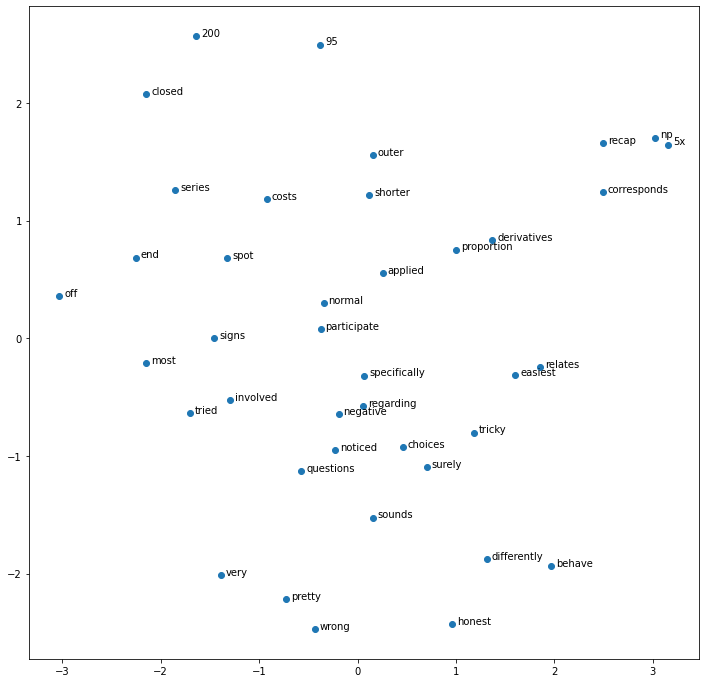

In [13]:
X = model[vocabulario_aleatorio]
pca = PCA(n_components=2)
result = pca.fit_transform(X)


plt.figure(figsize=(12, 12))
plt.scatter(result[:, 0], result[:, 1])
words = list(vocabulario_aleatorio)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0]+0.05, result[i, 1]))
plt.show()


#### Visualizamos los conjuntos de palabras similares

Utilizando distintos colores para cada grupo, visualizamos el conjunto de palabras obtenidas utilizando `most_similar` con el objeto de ver como se agrupan sus proyecciones

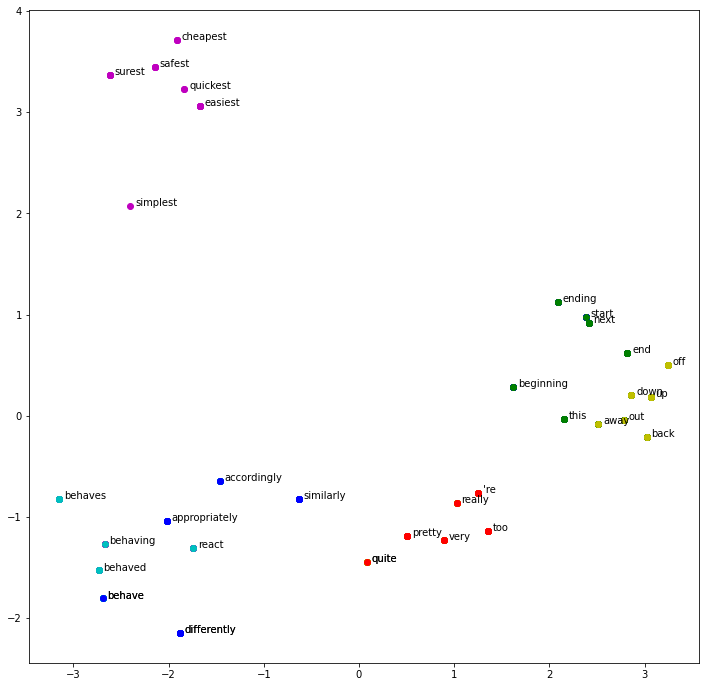

In [14]:
X = model[grupos_similares]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

colors = ["m","c", "b", "g","y","r"]

plt.figure(figsize=(12, 12))
#plt.scatter(result[:, 0], result[:, 1], color=next(colors))
words = list(grupos_similares)
for i, word in enumerate(words):
    plt.scatter(result[i:, 0], result[i:, 1], color=colors[i//6])
    plt.annotate(word, xy=(result[i, 0]+0.05, result[i, 1]))
plt.show()


## 9. Observaciones

Una de las limitaciones que a priori parecía evidente en el modelo pre entrenado que es la imposibilidad de utilizar tokens del vocabulario del dominio que no existen en el modelo, parece no tener un impacto tan grande medido en cantidad de palabras. 
Por supuesto que también hay otro aspecto que no hemos abordado aquí que es el hecho de que el embedding ha sido entrenado con un corpus en el que la relación entre las palabras no es la misma que en nuestro problema, por tanto es esperable que elementos como la utilización del lenguaje coloquial no aparezcan consideradas correctamente en el modelo pre entrenado